In [1]:
import copy
import operator
import sre_parse
import sre_constants
from functools import reduce
from random import Random
from importlib import reload
from dataclasses import asdict
from typing import Tuple
from collections import defaultdict, Counter

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib
from matplotlib.markers import Path as MarkerPath
from matplotlib.transforms import Affine2D
from matplotlib.collections import PatchCollection
import seaborn as sns
from ipywidgets import Accordion, HTML, VBox, HBox, Output, Button, Layout, Dropdown, Tab, Widget, GridBox, Text
from ipywidgets import Label, GridspecLayout
from tqdm import tqdm

In [3]:
import constants
reload(constants)
import solver
reload(solver)

<module 'solver' from '/data/Development/regex_crossword/solver.py'>

In [4]:
plt.style.use(['fivethirtyeight'])
pd.set_option('display.max_rows', 100)
pd.set_option('display.max_columns', 100)
pd.set_option('display.width', 400)
pd.set_option('display.max_colwidth', 400)

In [5]:
strings = solver.build_strings()

In [6]:
with tqdm(strings, desc='init solutions') as progress:
    solution_sets = [solver.SparseSolutionSet.for_string(s) for s in progress]

init solutions: 100%|██████████| 39/39 [00:01<00:00, 37.49it/s]


In [7]:
original_solution = reduce(lambda a, b: a.intersection(b), solution_sets)

In [8]:
len(original_solution.cells)

127

In [9]:
filter_solution = original_solution.filter_cells_using_other_unions()

In [10]:
cell_constraints = pd.Series([len(cc.constraint_dimensions) for cc in original_solution.cells.values()])
cell_constraints.value_counts().sort_index()

1     21
2     19
3     22
4     27
5     14
6      3
7      1
8      8
9      3
10     3
12     1
15     1
16     1
19     1
20     1
25     1
dtype: int64

In [11]:
reduce(operator.mul, cell_constraints)

915277226268156478636335823267529417048457216000000000000000000000

In [12]:
cell_constraints = pd.Series([len(cc.constraint_dimensions) for cc in filter_solution.cells.values()])
cell_constraints.value_counts().sort_index()

1     55
2     27
3     25
4      7
5      4
6      3
8      1
9      1
10     1
12     1
15     1
18     1
dtype: int64

In [13]:
reduce(operator.mul, cell_constraints)

586776166314128244404448657408000000

In [14]:
filter_solution2 = filter_solution.filter_cells_using_other_unions()

In [15]:
cell_constraints = pd.Series([len(cc.constraint_dimensions) for cc in filter_solution2.cells.values()])
cell_constraints.value_counts().sort_index()

1     75
2     26
3     14
4      3
5      2
6      3
8      2
12     1
15     1
dtype: int64

In [16]:
filter_solution_many = filter_solution2
with tqdm(range(100)) as progress:
    for _ in progress:
        filter_solution_many = filter_solution_many.filter_cells_using_other_unions()

100%|██████████| 100/100 [00:05<00:00, 19.88it/s]


In [17]:
cell_constraints = pd.Series([len(cc.constraint_dimensions) for cc in filter_solution_many.cells.values()])
cell_constraints.value_counts().sort_index()

1     100
2      18
3       2
4       2
5       1
6       1
8       2
10      1
dtype: int64

In [18]:
reduce(operator.mul, cell_constraints)

724775731200

In [19]:
lit_constraints = pd.Series({ix: frozenset(con.lit_component for con,comb in c.constraint_dimensions)
 for ix,c in filter_solution_many.cells.items()})

In [20]:
lit_constraints.map(len).value_counts()

1    110
2     16
3      1
dtype: int64

In [21]:
np.prod(lit_constraints.map(len))

196608

(-4.0, 15.0)

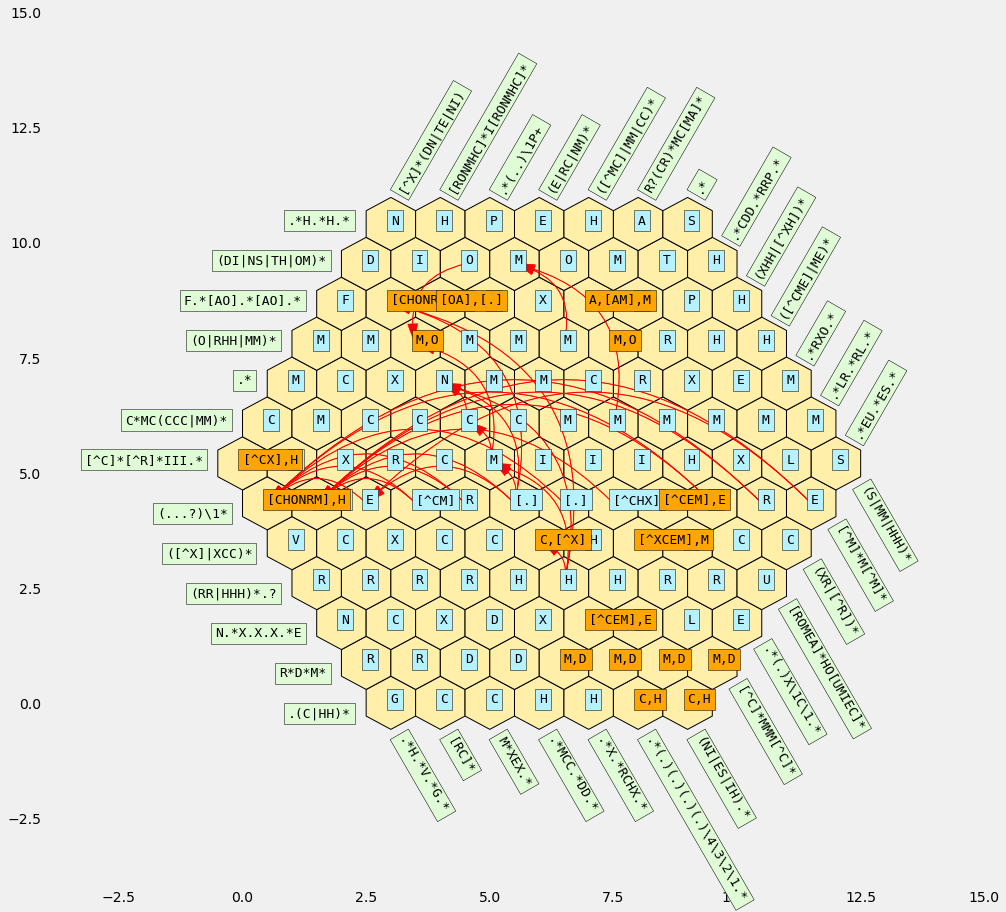

In [22]:
def merge_constraints(ix):
    lit_con, = lit_constraints[ix]
    cds = filter_solution_many.cells[ix].constraint_dimensions
    refs = frozenset(ref for con,comb in cds for ref in con.ref_component.indices)
    return lit_con if not refs else solver.CompoundConstraint(lit_con, solver.RefConstraint(refs))

drawer = solver.draw_puzzle(fig_size=15, solution=
                   solver.Solution({ix:merge_constraints(ix)
                                    for ix,ls in lit_constraints.items() if len(ls) == 1}))
for ix, ls in lit_constraints.items():
    if len(ls) == 1:
        continue
    x, y = drawer.position(*ix)
    drawer.text(x, y, ','.join(l.label() for l in ls), background_color='orange')
drawer.ax.grid(False)
plt.xlim(-4, 15)
plt.ylim(-4, 15)

In [28]:
push_solution = filter_solution_many.push_reference_constraints()

In [29]:
cell_constraints = pd.Series([len(cc.constraint_dimensions) for cc in push_solution.cells.values()])
cell_constraints.value_counts().sort_index()

1     101
2      17
3       2
4       2
5       1
6       1
8       2
10      1
dtype: int64

In [33]:
reduce(operator.mul, cell_constraints)

362387865600

In [39]:
[[[str(con), comb.size()] for con,comb in cell]
 for cell in push_solution.cells.values() if len(cell) > 1]

[[['R : 5,1', 2400], ['R : 5,0', 2400]],
 [['C : 7,4', 480], ['C', 1920], ['H : 7,4', 480], ['H', 1920]],
 [['[^CM] : 5,0', 2400], ['[^CM] : 5,1', 2400]],
 [['5,2', 960],
  ['5,2, 6,5', 480],
  ['5,2, 8,3', 480],
  ['5,2, 10,1', 480],
  ['5,1', 960],
  ['5,1, 6,5', 480],
  ['5,1, 8,3', 480],
  ['5,1, 10,1', 480]],
 [['[CHONRM]', 2400], ['H', 2400]],
 [['O : 5,0', 2400], ['O : 5,1', 2400]],
 [['D : 6,5', 576],
  ['D : 8,3', 576],
  ['D', 1728],
  ['M : 6,5', 384],
  ['M : 8,3', 384],
  ['M', 1152]],
 [['H : 4,5', 960],
  ['H : 6,5', 960],
  ['H : 8,3', 960],
  ['H : 10,1', 960],
  ['H', 960]],
 [['E', 2400], ['E : 5,0', 2400]],
 [['E : 5,2', 2400], ['E : 5,1', 2400]],
 [['[CHONRM]', 1600], ['O', 3200]],
 [['D', 960], ['M', 3840]],
 [['R : 5,1', 2400], ['R : 5,0', 2400]],
 [['C', 3840], ['C : 8,3', 960]],
 [['M', 1600], ['[AM]', 1600], ['A', 3200]],
 [['D', 1920], ['M', 480]],
 [['C', 2400], ['H', 2400]],
 [['D', 1920], ['M', 2880]],
 [['[^CEM] : 5,5', 480],
  ['[^CEM] : 7,4', 480],
  ['

In [46]:
comb = reduce(lambda a, b: a.intersection(b),
                      (c.union_constraint() for c in push_solution.cells.values()))
comb.size()

2400

In [53]:
list(filter(None, [0, 1, 2, None, 3, False, True]))

[1, 2, 3, True]

In [51]:
pd.Series({dim :sol.size(dim) for dim, sol in comb}).sort_values(ascending=False)

y1(45)      5
z5(5)       5
x9(89)      4
y10(28)     3
z0(35)      2
y0(13)      2
y5(2)       2
y3(12)      1
x12(10)     1
z3(21)      1
y7(27)      1
z2(7)       1
x4(1365)    1
y9(274)     1
x10(7)      1
z9(9)       1
z4(28)      1
y8(1)       1
y11(256)    1
x2(5)       1
x7(28)      1
y2(3)       1
x11(15)     1
x5(11)      1
z12(44)     1
z10(55)     1
y12(21)     1
y6(66)      1
y4(41)      1
x0(3)       1
z11(8)      1
x6(1)       1
z7(10)      1
x1(8)       1
z6(3)       1
x8(41)      1
z1(1)       1
x3(683)     1
z8(7)       1
dtype: int64

In [25]:
constrained_cell_solution = solver.Solution({ix:c.constraint_dimensions[0][0]
 for ix,c in filter_solution_many.cells.items() if len(c.constraint_dimensions) == 1})
constrained_cell_solution

<Solution cells=100>

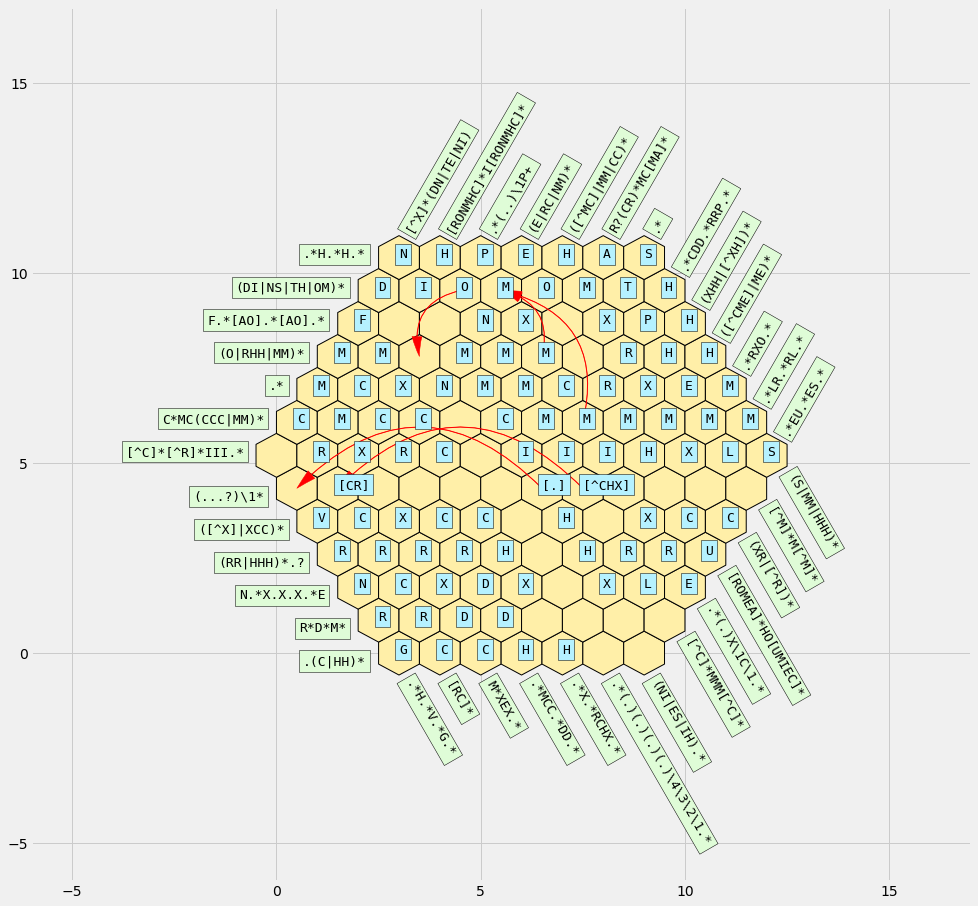

In [26]:
solver.draw_puzzle(fig_size=15, solution=constrained_cell_solution)

In [27]:
cds = min(s.cells.values(), key=lambda cc: len(cc.constraint_dimensions)).constraint_dimensions
cds

NameError: name 's' is not defined

In [ ]:
pd.Series(cds).map(lambda x: x[0])

In [ ]:
df = pd.DataFrame([{'cell': ix,
 'constraint': cc.constraint_dimensions[0][0],
  **{
      d:s for d,s in cc.constraint_dimensions[0][1].dimensions.items()
  }
 }
 for ix,cc in s.cells.items() if len(cc.constraint_dimensions) == 1]
).set_index(['cell', 'constraint']).sort_index().T.sort_index()

df

In [ ]:
dim_sizes = pd.concat([col.apply(lambda x: x.size(dim)) for dim,col in df.iterrows()], axis=1).T
dim_sizes

In [ ]:
dim_frac = dim_sizes.div(pd.Series(df.index, df.index).map(lambda x: x.size), axis=0).round(1)
dim_frac

In [ ]:
f = plt.figure(figsize=(8, 15))
ax = f.add_subplot(111)
sns.heatmap(dim_frac, linewidth=0.05, ax=ax)

In [ ]:
single_constraint_indexes = sorted(dim_frac.columns.get_level_values('cell'))
single_constraint_indexes

In [ ]:
acc = None
for ix in single_constraint_indexes:
    cds = s.cells[ix].constraint_dimensions
    assert len(cds) == 1
    comb = cds[0][1]
    if acc is None:
        acc = comb
    else:
        acc = comb.intersection(acc)

In [ ]:
single_constraint_sizes = pd.DataFrame([{'dim': dim,
  'total_size': dim.size,
  'sol_size': ds.size(dim)}
 for dim,ds in acc.dimensions.items()]
).set_index('dim').sort_index()

single_constraint_sizes['frac'] = (single_constraint_sizes['sol_size'] / single_constraint_sizes['total_size']).round(3)
single_constraint_sizes

In [ ]:
single_constraint_sizes['frac'].plot.hist()

In [ ]:
single_constraint_sizes['frac'].describe()

In [ ]:
single_constraint_sizes.sort_values('frac').head(10)

In [ ]:
df = pd.DataFrame([{d:s for d,s in x.dimensions.items()}
                   for _,x in cds],
                  index=[x for x,_ in cds])
df

In [ ]:
df.sort_index()

In [ ]:
df.T.sort_index()

In [ ]:
ds_counts = df.apply(Counter).sort_index()
ds_counts

In [ ]:
ds_counts_not_all = ds_counts[~ds_counts.map(lambda x: x.keys() == {solver.dimension_all})]
ds_counts_not_all

In [ ]:
x = df[ds_counts_not_all.index].copy().sort_index()
x

In [ ]:
y = pd.concat([col.map(lambda ds: ds.size(dim)) for dim, col in x.T.iterrows()], axis=1)
y['combs'] = np.prod(y, axis=1)
y

In [ ]:
dim = ds_counts_not_all.index[0]
dim

In [ ]:
df[dim].sort_index()

In [ ]:
df[dim].sort_index().map(lambda x: sorted(x.indexes))

In [ ]:
pd.Series(list(reduce(lambda a,b: a | b, df[dim].sort_index().map(lambda x: x.indexes))))

In [ ]:
pd.Series(reduce(lambda a,b : a + b,
                 df[dim].sort_index().map(lambda x: list(x.indexes)))
).value_counts()

In [ ]:
lit_cons = defaultdict(list)
for con in df.index:
    lit_cons[con.lit_component].append(con)
lit_cons

In [ ]:
list(s.cells.values())[0].constraint_dimensions

In [ ]:
lit_cell_constraints = pd.Series([len({con.lit_component for con, comb in cc.constraint_dimensions})
                              for cc in s.cells.values()])
lit_cell_constraints.value_counts().sort_index()

In [ ]:
reduce(operator.mul, lit_cell_constraints)

In [ ]:
reduce(operator.mul, cell_constraints) / reduce(operator.mul, lit_cell_constraints)

In [ ]:
cds = list(s.cells.values())[lit_cell_constraints.idxmax()].constraint_dimensions
cds

In [ ]:
df = pd.DataFrame([{d:s for d,s in x.dimensions.items()}
                   for _,x in cds],
                  index=[x for x,_ in cds]).sort_index()
df

In [ ]:
df.T

In [ ]:
ds_counts = df.apply(Counter).sort_index()
ds_counts

In [ ]:
ds_counts_not_all = ds_counts[~ds_counts.map(lambda x: x.keys() == {solver.dimension_all})]
ds_counts_not_all

In [ ]:
x = df[ds_counts_not_all.index].copy().sort_index()
x['combs'] = np.prod(x.applymap(lambda x: len(x.indexes)), axis=1)
x

In [ ]:
cell_refs = set()
for ix,ccs in s.cells.items():
    for con, comb in ccs.constraint_dimensions:
        for target_ix in con.ref_component.indices:
            cell_refs.add((ix, target_ix, con.lit_component))
cell_refs = pd.DataFrame(list(map(list, cell_refs)), columns=['source', 'target', 'source_con'])
cell_refs['target_cons'] = cell_refs['target'].map(
    lambda ix: frozenset(con for con,comb in s.cells[ix].constraint_dimensions))
print(len(cell_refs))
cell_refs.sample(10)

In [ ]:
x = (cell_refs
 [cell_refs['source'].isin(cell_refs['source'].drop_duplicates().sample(5, random_state=0xCAFE))]
 .groupby('source'))
for source, y in x:
    print(source)
    display(y.sort_values('target'))

In [ ]:
set(cell_refs['source']) & set(cell_refs['target'])

In [ ]:
cds = s.cells[(10, 4)].constraint_dimensions
cds

In [ ]:
df = pd.DataFrame([{d:s for d,s in x.dimensions.items()}
                   for _,x in cds],
                  index=[x for x,_ in cds])
df

In [ ]:
ds_counts = df.apply(Counter).sort_index()
ds_counts

In [ ]:
ds_counts_not_all = ds_counts[~ds_counts.map(lambda x: x.keys() == {solver.dimension_all})]
ds_counts_not_all

In [ ]:
x = df[ds_counts_not_all.index].copy().sort_index()
x

In [ ]:
y = pd.concat([col.map(lambda ds: ds.size(dim)) for dim, col in x.T.iterrows()], axis=1)
y['combs'] = np.prod(y, axis=1)
y

In [ ]:
drawer = solver.draw_puzzle(fig_size=15)
for i,(source, target) in cell_refs[['source', 'target']].drop_duplicates().iterrows():
    drawer.draw_arrow(drawer.position(*source), drawer.position(*target))